Simulation goals

* Study the transportation plan between different embedding spaces

* Specifically, we will simulate well-studied embeddings first, then simulate the features, and simulate labels

* Assume index starts from 1 in the simulation scheme

Simulation

* $l$: embedding dimension. $l=2$ in this simulation.

* $n$: total number of patients per domain

* $r \in \{1, 2\}$ for indexing domains

* $k \in [D]$ for indexing feature

* $i$ for indexing patient

* Generate relatively equal number of 1's and 2's for $Y_r$.

* Generate $E'_r$, the desired embedding space, in the following way, where $\epsilon$ is a random noise generator

    * When $r=1$, if $Y_{1i}$ is 1, $E'_{1i} = [-1, -1]+1.5\times\epsilon(E'_1)$  

    * When $r=1$, if $Y_{1i}$ is 2, $E'_{1i} = [1, 0]+2\times\epsilon(E'_1)$ 

    * When $r=2$, if $Y_{2i}$ is 1, $E'_{2i} = [-2, -2]+\epsilon(E'_2)$ 
    
    * When $r=2$, if $Y_{2i}$ is 2, $E'_{2i} = [2, 0]+2\times\epsilon(E'_2)$ 

* Sample desired decoder parameters $w_{r} \sim \operatorname{Unif}\left(-0.5,0.5\right)$ and $b_{r} \sim \operatorname{Unif}\left(0, 1\right)$ # TODO: this does not work, cannot directly sample parameters

* Generate features $X_r \sim \operatorname{decoder}\left(E'_r, w_r, b_r\right)$ 

After simulation

* Compute $\tilde{E'_2}$, the sinkhorn transported $E'_2$ onto $E'_1$

* Visualize $E'_1$, $E'_2$, $\tilde{E'_2}$ with class labels, check if it is the class are more seperated after transportation.



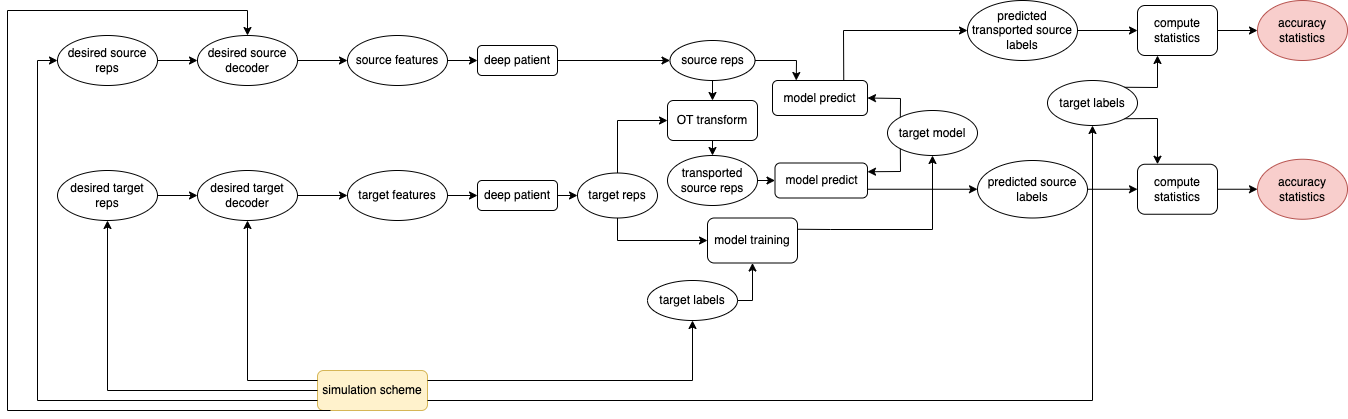

In [1]:
from IPython.display import Image
Image(filename='../outputs/EHR_emb_sim_pipeline.png')

In [2]:
import sys
sys.path.append("/home/wanxinli/OTTEHR/synthetic_exp")

from common import *
from OTTEHR.sda import SDA
from math import floor, exp
import matplotlib.pylab as pl
import numpy as np
from numpy.random import poisson
import theano.tensor as T
from sklearn import linear_model
from sklearn import svm
from sklearn.utils import check_random_state


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
def simulate_emb_label(dataset, n, nz=.5, theta=0, p=.5, random_state=None, **kwargs):
    """ Simulate desired embeddings and labels
 
    Parameters
    ----------
    dataset : str
        type of classification problem (see code)
    n : int
        number of training samples
    nz : float
        noise level (>0)
    p : float
        proportion of one class in the binary setting
    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.

    Returns
    -------
    X : ndarray, shape (n, d), the desired embedding
        `n` observation of size `d`
    y : ndarray, shape (n,), the labels
        labels of the samples.
    """
    
    generator = check_random_state(random_state)

    if dataset.lower() == '2gauss': # this pair of simulation can be transported well
        y = np.floor((np.arange(n) * 1.0 / n * 2)) + 1
        x = np.zeros((n, 2))
        # class 1
        x[y == 1, 0] = -1
        x[y == 1, 1] = -1
        x[y == 2, 0] = 1
        x[y == 2, 1] = 0
        x[y != 2, :] += 1.5 * nz * generator.randn(sum(y != 2), 2)
        x[y == 2, :] += 2 * nz * generator.randn(sum(y == 2), 2)
    elif dataset.lower() == '2gauss2':
        y = np.floor((np.arange(n) * 1.0 / n * 2)) + 1
        x = np.zeros((n, 2))
        # class 1
        x[y == 1, 0] = -2.
        x[y == 1, 1] = -2.
        x[y == 2, 0] = 2.
        x[y == 2, 1] = 0.
        x[y != 2, :] += 1 * nz * generator.randn(sum(y != 2), 2)
        x[y == 2, :] += 2 * nz * generator.randn(sum(y == 2), 2)
        
    return x, y.astype(int)

In [4]:
def sample_vae_params(l, feature_len):
    """ 
    Sample deep patient parameters necessary for reconstructing the data \
        from the representation per domain
    
    :param int l: the embedding dimension
    :param int feature_len: the feature cardinality 

    return 
        - wp, dimension is l x (# of visible units) (see da.py)
        - bp, dimension is 1 x (# of visible units) (see da.py)
    """
    wp = np.random.uniform(low=-0.5, high=0.5, size=[l, feature_len])
    # bp = np.random.uniform(size=[1, feature_len])
    bp = np.random.uniform(low=0, high=0, size=[1, feature_len])
    return wp, bp

In [5]:
def gen_features(wp, bp, embeddings):
    """ 
    Generate features based on embeddings, including
    - transform
    - denormalize
    """
    normalized_features = T.nnet.sigmoid(T.dot(embeddings, wp) + bp).eval()
    # print("normalized_feature is:", normalized_features)
    denormalized_features = np.empty(shape=normalized_features.shape)

    sigma = 10 # TODO: can also simulate this parameter
    for i in range(len(normalized_features)):
        denormalized_features[i] = [feature*sigma for feature in normalized_features[i]]

    normalized_min = normalized_features.min()
    normalized_incre = 0
    if normalized_min < 0:
        normalized_incre = -normalized_min
    for i in range(len(denormalized_features)):
        denormalized_features[i] = [int(feature+normalized_incre) for feature in denormalized_features[i]]

    return denormalized_features

In [6]:
"""
Train deep patient model and generate representations for targets and sources
"""

def custom_train_reps(target_seqs, source_seqs):
    """ 
    Customized training algorithm for generating target representations and source representations
    
    :returns: target representations, source representations
    """

    # customized parameters
    nhidden = 2
    nlayer = 1

    # for targets
    # initiate the model
    target_sda = SDA(target_seqs.shape[1],
                nhidden=nhidden,
                nlayer=nlayer,
                param={
        'epochs': 1000,
        'batch_size':32,
        'corrupt_lvl': 0
    })

    # train the model
    target_sda.train(target_seqs)

    # apply the mode
    target_reps = target_sda.apply(target_seqs)

    # for sources
    # initiate the model
    source_sda = SDA(source_seqs.shape[1],
                nhidden=nhidden,
                nlayer=nlayer,
                param={
        'epochs': 1000,
        'batch_size': 32,
        'corrupt_lvl': 0
    })

    # train the model
    source_sda.train(source_seqs)

    # apply the mode
    source_reps = source_sda.apply(source_seqs)
    return target_reps, source_reps


In [7]:
def vis_emb(target_reps, target_labels, source_reps, source_labels, trans_source_reps):
    pl.figure(1, figsize=(15, 5))
    pl.subplot(1, 3, 1)
    pl.scatter(source_reps[:, 0], source_reps[:, 1], c=source_labels, marker='+', label='Source samples')
    # pl.xticks([])
    # pl.yticks([])
    pl.legend(loc=0)
    pl.title('Source  samples')

    pl.subplot(1, 3, 2)
    pl.scatter(target_reps[:, 0], target_reps[:, 1], c=target_labels, marker='o', label='Target samples')
    # pl.xticks([])
    # pl.yticks([])
    pl.legend(loc=0)
    pl.title('Target samples')
    pl.tight_layout()

    pl.subplot(1, 3, 3)
    pl.scatter(trans_source_reps[:, 0], trans_source_reps[:, 1], c=source_labels, marker='+', label='Transported source samples')
    # pl.xticks([])
    # pl.yticks([])
    pl.legend(loc=0)
    pl.title('Transported source samples')
    pl.tight_layout()
    pl.show()

In [8]:
def simulation(num_patient):
    source_desired_reps, source_labels = simulate_emb_label('2gauss', num_patient)
    target_desired_reps, target_labels = simulate_emb_label('2gauss2', num_patient)
    embedding_dim = 2
    target_feature_len = 6
    source_feature_len = 6
    target_wp, target_bp = sample_vae_params(embedding_dim, target_feature_len)
    source_wp, source_bp = sample_vae_params(embedding_dim, source_feature_len)
    target_features = gen_features(target_wp, target_bp, target_desired_reps)
    source_features = gen_features(source_wp, source_bp, source_desired_reps)
    return target_features, target_labels, source_features, source_labels


In [9]:
def entire_proc_emb(num_patient):
    
    target_reps, source_reps = custom_train_reps(target_features, source_features)
    # trans_source_reps = trans_source2target(source_reps, target_reps)

    ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1, max_iter=1000000)
    ot_sinkhorn.fit(Xs=source_reps, Xt=target_reps)
    trans_source_reps = ot_sinkhorn.transform(Xs=source_reps)

    # vis(target_reps, target_labels, source_reps, source_labels, trans_source_reps)
    target_accuracy, target_precision, target_recall, target_f1, \
        source_accuracy, source_precision, source_recall, source_f1, \
        trans_source_accuracy, trans_source_precision, trans_source_recall, trans_source_f1 = \
        cal_stats_binary(target_reps, target_labels, source_reps, source_labels, \
        trans_source_reps, svm.SVC)
    return target_accuracy, target_precision, target_recall, target_f1, \
        source_accuracy, source_precision, source_recall, source_f1, \
        trans_source_accuracy, trans_source_precision, trans_source_recall, trans_source_f1
    

In [10]:
target_accuracy, target_precision, target_recall, target_f1, \
            source_accuracy, source_precision, source_recall, source_f1, \
            trans_source_accuracy, trans_source_precision, trans_source_recall, trans_source_f1 = \
                    entire_proc_binary(simulation, custom_train_reps, svm.SVC)

initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 1000

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 5.382
(*) epoch 2, cost 3.557
(*) epoch 3, cost 3.317
(*) epoch 4, cost 3.043
(*) epoch 5, cost 2.810
(*) epoch 6, cost 2.641
(*) epoch 7, cost 2.524
(*) epoch 8, cost 2.443
(*) epoch 9, cost 2.386
(*) epoch 10, cost 2.345
(*) epoch 11, cost 2.315
(*) epoch 12, cost 2.292
(*) epoch 13, cost 2.274
(*) epoch 14, cost 2.260
(*) epoch 15, cost 2.248
(*) epoch 16, cost 2.238
(*) training time: 0.05 sec.

training time: 1.33 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 100

In [14]:
target_accuracies, target_precisions, target_recalls, target_f1s, \
        source_accuracies, source_precisions, source_recalls, source_f1s, \
        trans_source_accuracies, trans_source_precisions, trans_source_recalls, trans_source_f1s = \
        run_proc_multi(simulation, custom_train_reps, svm.SVC, n_times = 100)


initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 1000

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 4.211
(*) epoch 2, cost 4.008
(*) epoch 3, cost 3.974
(*) epoch 4, cost 3.936
(*) epoch 5, cost 3.885
(*) epoch 6, cost 3.819
(*) epoch 7, cost 3.744
(*) epoch 8, cost 3.665
(*) epoch 9, cost 3.591
(*) epoch 10, cost 3.526
(*) epoch 11, cost 3.472
(*) epoch 12, cost 3.428
(*) epoch 13, cost 3.395
(*) epoch 14, cost 3.369
(*) epoch 15, cost 3.349
(*) epoch 16, cost 3.333
(*) epoch 17, cost 3.321
(*) epoch 18, cost 3.312
(*) training time: 0.05 sec.

training time: 0.32 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning ra

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(*) epoch 1, cost 4.298
(*) epoch 2, cost 3.956
(*) epoch 3, cost 3.893
(*) epoch 4, cost 3.853
(*) epoch 5, cost 3.821
(*) epoch 6, cost 3.794
(*) epoch 7, cost 3.770
(*) epoch 8, cost 3.747
(*) epoch 9, cost 3.725
(*) epoch 10, cost 3.704
(*) epoch 11, cost 3.685
(*) epoch 12, cost 3.667
(*) epoch 13, cost 3.650
(*) epoch 14, cost 3.634
(*) epoch 15, cost 3.620
(*) epoch 16, cost 3.608
(*) epoch 17, cost 3.597
(*) epoch 18, cost 3.587
(*) training time: 0.05 sec.

training time: 0.23 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 1000

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 5.069
(*) epoch 2, cost 4.069
(*) epoch 3, cost 4.023
(*) epoch 4, cost 4.021
(*) training time: 0.01 sec.

training time: 0.27 sec.

apply

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(*) epoch 1, cost 4.127
(*) epoch 2, cost 3.888
(*) epoch 3, cost 3.825
(*) epoch 4, cost 3.770
(*) epoch 5, cost 3.720
(*) epoch 6, cost 3.675
(*) epoch 7, cost 3.636
(*) epoch 8, cost 3.603
(*) epoch 9, cost 3.575
(*) epoch 10, cost 3.551
(*) epoch 11, cost 3.531
(*) epoch 12, cost 3.513
(*) epoch 13, cost 3.498
(*) epoch 14, cost 3.485
(*) epoch 15, cost 3.473
(*) epoch 16, cost 3.462
(*) epoch 17, cost 3.453
(*) training time: 0.05 sec.

training time: 0.21 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 1000

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 4.116
(*) epoch 2, cost 4.097
(*) epoch 3, cost 4.091
(*) training time: 0.01 sec.

training time: 0.16 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
init

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(*) epoch 1, cost 4.277
(*) epoch 2, cost 3.989
(*) epoch 3, cost 3.965
(*) epoch 4, cost 3.954
(*) epoch 5, cost 3.945
(*) training time: 0.01 sec.

training time: 0.29 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 1000

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 3.972
(*) epoch 2, cost 3.816
(*) epoch 3, cost 3.756
(*) epoch 4, cost 3.710
(*) epoch 5, cost 3.664
(*) epoch 6, cost 3.615
(*) epoch 7, cost 3.562
(*) epoch 8, cost 3.506
(*) epoch 9, cost 3.448
(*) epoch 10, cost 3.389
(*) epoch 11, cost 3.331
(*) epoch 12, cost 3.276
(*) epoch 13, cost 3.225
(*) epoch 14, cost 3.179
(*) epoch 15, cost 3.139
(*) epoch 16, cost 3.104
(*) epoch 17, cost 3.073
(*) epoch 18, cost 3.047
(*) epoch 19, cost 3.024
(*) epoch 20

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 1000

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 4.500
(*) epoch 2, cost 3.838
(*) epoch 3, cost 3.792
(*) epoch 4, cost 3.756
(*) epoch 5, cost 3.719
(*) epoch 6, cost 3.679
(*) epoch 7, cost 3.638
(*) epoch 8, cost 3.597
(*) epoch 9, cost 3.557
(*) epoch 10, cost 3.519
(*) epoch 11, cost 3.484
(*) epoch 12, cost 3.452
(*) epoch 13, cost 3.424
(*) epoch 14, cost 3.400
(*) epoch 15, cost 3.380
(*) epoch 16, cost 3.362
(*) epoch 17, cost 3.347
(*) epoch 18, cost 3.335
(*) epoch 19, cost 3.324
(*) epoch 20, cost 3.315
(*) training time: 0.06 sec.

training time: 0.21 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units:

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 1000

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 4.291
(*) epoch 2, cost 3.644
(*) epoch 3, cost 3.503
(*) epoch 4, cost 3.379
(*) epoch 5, cost 3.264
(*) epoch 6, cost 3.161
(*) epoch 7, cost 3.075
(*) epoch 8, cost 3.005
(*) epoch 9, cost 2.950
(*) epoch 10, cost 2.906
(*) epoch 11, cost 2.872
(*) epoch 12, cost 2.845
(*) epoch 13, cost 2.824
(*) epoch 14, cost 2.807
(*) epoch 15, cost 2.793
(*) epoch 16, cost 2.781
(*) epoch 17, cost 2.771
(*) training time: 0.05 sec.

training time: 0.21 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 1000



/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 1000

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 4.992
(*) epoch 2, cost 3.910
(*) epoch 3, cost 3.844
(*) epoch 4, cost 3.800
(*) epoch 5, cost 3.754
(*) epoch 6, cost 3.711
(*) epoch 7, cost 3.671
(*) epoch 8, cost 3.634
(*) epoch 9, cost 3.603
(*) epoch 10, cost 3.576
(*) epoch 11, cost 3.553
(*) epoch 12, cost 3.534
(*) epoch 13, cost 3.518
(*) epoch 14, cost 3.505
(*) epoch 15, cost 3.494
(*) epoch 16, cost 3.485
(*) training time: 0.05 sec.

training time: 0.31 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 100

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 1000

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 4.441
(*) epoch 2, cost 3.879
(*) epoch 3, cost 3.777
(*) epoch 4, cost 3.696
(*) epoch 5, cost 3.617
(*) epoch 6, cost 3.544
(*) epoch 7, cost 3.481
(*) epoch 8, cost 3.428
(*) epoch 9, cost 3.386
(*) epoch 10, cost 3.353
(*) epoch 11, cost 3.327
(*) epoch 12, cost 3.306
(*) epoch 13, cost 3.290
(*) epoch 14, cost 3.276
(*) epoch 15, cost 3.265
(*) epoch 16, cost 3.256
(*) training time: 0.05 sec.

training time: 0.21 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 100

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(*) epoch 1, cost 4.514
(*) epoch 2, cost 4.061
(*) epoch 3, cost 4.033
(*) epoch 4, cost 4.022
(*) epoch 5, cost 4.008
(*) epoch 6, cost 3.987
(*) epoch 7, cost 3.957
(*) epoch 8, cost 3.915
(*) epoch 9, cost 3.863
(*) epoch 10, cost 3.803
(*) epoch 11, cost 3.742
(*) epoch 12, cost 3.683
(*) epoch 13, cost 3.630
(*) epoch 14, cost 3.582
(*) epoch 15, cost 3.541
(*) epoch 16, cost 3.505
(*) epoch 17, cost 3.475
(*) epoch 18, cost 3.449
(*) epoch 19, cost 3.427
(*) epoch 20, cost 3.409
(*) epoch 21, cost 3.393
(*) epoch 22, cost 3.380
(*) epoch 23, cost 3.368
(*) epoch 24, cost 3.359
(*) training time: 0.07 sec.

training time: 0.23 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 1000

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epo

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 1000

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 3.742
(*) epoch 2, cost 3.554
(*) epoch 3, cost 3.501
(*) epoch 4, cost 3.471
(*) epoch 5, cost 3.449
(*) epoch 6, cost 3.432
(*) epoch 7, cost 3.419
(*) epoch 8, cost 3.408
(*) epoch 9, cost 3.399
(*) training time: 0.03 sec.

training time: 0.19 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 1000

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 4.687
(*) epoch 2, cost 4.034
(*) epoch 3, cost 4.013
(*) epoch 4, c

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 1000

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 4.577
(*) epoch 2, cost 4.003
(*) epoch 3, cost 3.981
(*) epoch 4, cost 3.964
(*) epoch 5, cost 3.944
(*) epoch 6, cost 3.922
(*) epoch 7, cost 3.896
(*) epoch 8, cost 3.865
(*) epoch 9, cost 3.828
(*) epoch 10, cost 3.783
(*) epoch 11, cost 3.731
(*) epoch 12, cost 3.673
(*) epoch 13, cost 3.615
(*) epoch 14, cost 3.561
(*) epoch 15, cost 3.518
(*) epoch 16, cost 3.484
(*) epoch 17, cost 3.460
(*) epoch 18, cost 3.442
(*) epoch 19, cost 3.430
(*) epoch 20, cost 3.421
(*) training time: 0.06 sec.

training time: 0.22 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units:

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 1000

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 4.574
(*) epoch 2, cost 3.508
(*) epoch 3, cost 3.386
(*) epoch 4, cost 3.323
(*) epoch 5, cost 3.279
(*) epoch 6, cost 3.247
(*) epoch 7, cost 3.225
(*) epoch 8, cost 3.208
(*) epoch 9, cost 3.195
(*) epoch 10, cost 3.185
(*) training time: 0.03 sec.

training time: 0.18 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 1000

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 4.250
(*) epoch 2, cost 3.954
(*) epoch 3, cost 3.927
(*) epoch 4, cost

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 1000

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 4.432
(*) epoch 2, cost 3.739
(*) epoch 3, cost 3.617
(*) epoch 4, cost 3.531
(*) epoch 5, cost 3.463
(*) epoch 6, cost 3.411
(*) epoch 7, cost 3.371
(*) epoch 8, cost 3.342
(*) epoch 9, cost 3.321
(*) epoch 10, cost 3.306
(*) epoch 11, cost 3.295
(*) epoch 12, cost 3.287
(*) training time: 0.04 sec.

training time: 0.30 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 1000

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 1000

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 4.150
(*) epoch 2, cost 4.003
(*) epoch 3, cost 4.000
(*) training time: 0.01 sec.

training time: 0.17 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 1000

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 4.452
(*) epoch 2, cost 3.657
(*) epoch 3, cost 3.551
(*) epoch 4, cost 3.514
(*) epoch 5, cost 3.488
(*) epoch 6, cost 3.467
(*) epoch 7, cost 3.450
(*) epoch 8, cost 3.436
(*) epoch 9, cost 3.425
(*) epoch 10, 

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 1000

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 4.514
(*) epoch 2, cost 3.959
(*) epoch 3, cost 3.929
(*) epoch 4, cost 3.907
(*) epoch 5, cost 3.883
(*) epoch 6, cost 3.854
(*) epoch 7, cost 3.822
(*) epoch 8, cost 3.787
(*) epoch 9, cost 3.750
(*) epoch 10, cost 3.713
(*) epoch 11, cost 3.676
(*) epoch 12, cost 3.640
(*) epoch 13, cost 3.607
(*) epoch 14, cost 3.577
(*) epoch 15, cost 3.550
(*) epoch 16, cost 3.526
(*) epoch 17, cost 3.504
(*) epoch 18, cost 3.486
(*) epoch 19, cost 3.470
(*) epoch 20, cost 3.456
(*) epoch 21, cost 3.444
(*) epoch 22, cost 3.434
(*) epoch 23, cost 3.425
(*) training time: 0.07 sec.

training time: 0.22 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

init

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 1000

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 3.964
(*) epoch 2, cost 3.691
(*) epoch 3, cost 3.582
(*) epoch 4, cost 3.493
(*) epoch 5, cost 3.413
(*) epoch 6, cost 3.341
(*) epoch 7, cost 3.276
(*) epoch 8, cost 3.218
(*) epoch 9, cost 3.167
(*) epoch 10, cost 3.121
(*) epoch 11, cost 3.081
(*) epoch 12, cost 3.045
(*) epoch 13, cost 3.014
(*) epoch 14, cost 2.986
(*) epoch 15, cost 2.961
(*) epoch 16, cost 2.939
(*) epoch 17, cost 2.919
(*) epoch 18, cost 2.901
(*) epoch 19, cost 2.885
(*) epoch 20, cost 2.871
(*) epoch 21, cost 2.857
(*) epoch 22, cost 2.846
(*) epoch 23, cost 2.835
(*) epoch 24, cost 2.825
(*) training time: 0.07 sec.

training time: 0.23 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initial

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 1000

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 5.235
(*) epoch 2, cost 3.992
(*) epoch 3, cost 3.909
(*) epoch 4, cost 3.881
(*) epoch 5, cost 3.844
(*) epoch 6, cost 3.800
(*) epoch 7, cost 3.750
(*) epoch 8, cost 3.698
(*) epoch 9, cost 3.646
(*) epoch 10, cost 3.597
(*) epoch 11, cost 3.552
(*) epoch 12, cost 3.513
(*) epoch 13, cost 3.480
(*) epoch 14, cost 3.453
(*) epoch 15, cost 3.430
(*) epoch 16, cost 3.411
(*) epoch 17, cost 3.396
(*) epoch 18, cost 3.383
(*) epoch 19, cost 3.373
(*) epoch 20, cost 3.364
(*) training time: 0.06 sec.

training time: 0.21 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units:

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 1000

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 4.066
(*) epoch 2, cost 3.596
(*) epoch 3, cost 3.546
(*) epoch 4, cost 3.523
(*) epoch 5, cost 3.506
(*) epoch 6, cost 3.491
(*) epoch 7, cost 3.478
(*) epoch 8, cost 3.468
(*) epoch 9, cost 3.459
(*) training time: 0.03 sec.

training time: 0.29 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 1000

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 3.991
(*) epoch 2, cost 3.798
(*) epoch 3, cost 3.757
(*) epoch 4, c

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 1000

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 4.326
(*) epoch 2, cost 3.860
(*) epoch 3, cost 3.785
(*) epoch 4, cost 3.725
(*) epoch 5, cost 3.666
(*) epoch 6, cost 3.607
(*) epoch 7, cost 3.552
(*) epoch 8, cost 3.502
(*) epoch 9, cost 3.459
(*) epoch 10, cost 3.424
(*) epoch 11, cost 3.396
(*) epoch 12, cost 3.374
(*) epoch 13, cost 3.357
(*) epoch 14, cost 3.345
(*) epoch 15, cost 3.335
(*) training time: 0.04 sec.

training time: 0.21 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 1000

training: 1-layer SDAs

training: DA [layer: 1]
(*

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 1000

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 5.406
(*) epoch 2, cost 4.021
(*) epoch 3, cost 3.931
(*) epoch 4, cost 3.874
(*) epoch 5, cost 3.820
(*) epoch 6, cost 3.771
(*) epoch 7, cost 3.727
(*) epoch 8, cost 3.688
(*) epoch 9, cost 3.655
(*) epoch 10, cost 3.627
(*) epoch 11, cost 3.603
(*) epoch 12, cost 3.583
(*) epoch 13, cost 3.566
(*) epoch 14, cost 3.552
(*) epoch 15, cost 3.540
(*) epoch 16, cost 3.530
(*) epoch 17, cost 3.521
(*) training time: 0.05 sec.

training time: 0.21 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 1000

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 3.728
(*) epoch 2, cost 3.100
(*) epoch 3, cost 2.959
(*) epoch 4, cost 2.876
(*) epoch 5, cost 2.813
(*) epoch 6, cost 2.761
(*) epoch 7, cost 2.718
(*) epoch 8, cost 2.682
(*) epoch 9, cost 2.650
(*) epoch 10, cost 2.622
(*) epoch 11, cost 2.597
(*) epoch 12, cost 2.575
(*) epoch 13, cost 2.555
(*) epoch 14, cost 2.536
(*) epoch 15, cost 2.519
(*) epoch 16, cost 2.503
(*) epoch 17, cost 2.489
(*) epoch 18, cost 2.476
(*) epoch 19, cost 2.463
(*) epoch 20, cost 2.452
(*) epoch 21, cost 2.441
(*) epoch 22, cost 2.432
(*) training time: 0.07 sec.

training time: 0.23 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 1000

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 4.170
(*) epoch 2, cost 3.872
(*) epoch 3, cost 3.790
(*) epoch 4, cost 3.715
(*) epoch 5, cost 3.652
(*) epoch 6, cost 3.603
(*) epoch 7, cost 3.565
(*) epoch 8, cost 3.536
(*) epoch 9, cost 3.515
(*) epoch 10, cost 3.498
(*) epoch 11, cost 3.485
(*) epoch 12, cost 3.476
(*) training time: 0.03 sec.

training time: 0.30 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 1000

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 5.675
(*) epoch 2, co

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 1000

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 4.422
(*) epoch 2, cost 3.802
(*) epoch 3, cost 3.608
(*) epoch 4, cost 3.403
(*) epoch 5, cost 3.258
(*) epoch 6, cost 3.175
(*) epoch 7, cost 3.130
(*) epoch 8, cost 3.103
(*) epoch 9, cost 3.087
(*) epoch 10, cost 3.076
(*) epoch 11, cost 3.069
(*) training time: 0.03 sec.

training time: 0.19 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 1000

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 4.343
(*) epoch 2,

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 1000

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 4.338
(*) epoch 2, cost 3.967
(*) epoch 3, cost 3.924
(*) epoch 4, cost 3.883
(*) epoch 5, cost 3.829
(*) epoch 6, cost 3.765
(*) epoch 7, cost 3.698
(*) epoch 8, cost 3.633
(*) epoch 9, cost 3.575
(*) epoch 10, cost 3.526
(*) epoch 11, cost 3.486
(*) epoch 12, cost 3.455
(*) epoch 13, cost 3.431
(*) epoch 14, cost 3.412
(*) epoch 15, cost 3.398
(*) epoch 16, cost 3.387
(*) epoch 17, cost 3.379
(*) training time: 0.05 sec.

training time: 0.23 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 2
(*) data corruption level: 0.00
(*) learning rate: 0.10
(*) batch size: 

In [15]:
score_path = "../outputs/sim3_svm_scores.csv"
save_scores(target_accuracies, target_precisions, target_recalls, target_f1s, \
        source_accuracies, source_precisions, source_recalls, source_f1s, \
        trans_source_accuracies, trans_source_precisions, trans_source_recalls, trans_source_f1s, score_path)

average trans source to source accuracy increment is -0.9%
median trans source to source accuracy increment is -0.2%
average trans source to source accuracy f1 is 6.1%
median trans source to source accuracy f1 is 1.4%


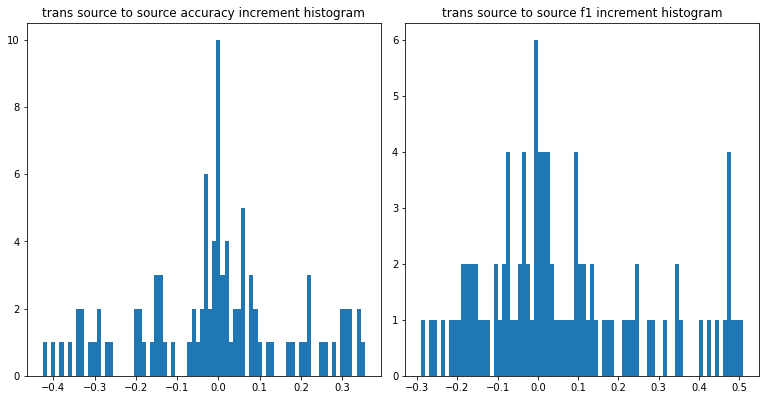

In [16]:
""" 
Larger is better (>0)
"""
hist_plot(score_path, filter=False)

In [ ]:
# def sigmoid(x):
#   return 1 / (1 + np.exp(-x))

# def inv_sigmoid(y):
#   return np.log(y/(1-y))


In [ ]:
# class DE:
#     """ 
#     One decoder_encoder per domain
#     """

#     feature_len = None
#     embedding_dim = None
#     w = None
#     b = None
#     wp = None
#     bp = None
#     sigma = None

#     def __init__(self, feature_len, embedding_dim=2):
#         """
#         Initialize feature length and embedding dimension
#         """
#         self.feature_len = feature_len
#         self.embedding_dim = embedding_dim
#         self.sample_decoder_params()

#     def sample_decoder_params(self):
#         """ 
#         Sample deep patient parameters necessary for reconstructing the data \
#             from the representation per domain
        
#         :param int l: the embedding dimension
#         :param int feature_len: the feature cardinality 

#         return 
#             - w, dimension is l x (# of visible units) (see da.py)
#             - b, dimension is 1 x (# of visible units) (see da.py)
#             - sigma, scalle number
#         """
#         self.w = np.random.uniform(low=-0.5, high=0.5, size=[self.feature_len, self.embedding_dim])
#         # self.w = np.array([[2,3], [1,2], [4,7], [9,3], [2,4]])
#         print("w is:", self.w)
#         self.b = np.random.uniform(size=[1, self.feature_len])
#         self.b = np.zeros(shape=[1, self.feature_len])
#         # self.sigma = np.random.uniform(low=10, high=20)
#         self.sigma=10
#         self.wp = self.w.T


#     def decoder(self, embedding):
#         """ 
#         Decode embedding into features
#         """
#         print("embedding shape is:", embedding.shape)
#         print("wp is:", self.wp)
#         print("matmul is:", np.matmul(self.w, self.wp))
#         print("inverse is:", np.linalg.inv(np.matmul(self.w, self.wp)))
#         temp = np.matmul(self.wp, np.linalg.inv(np.matmul(self.w, self.wp)))
#         print("temp is:", temp)
        
#         normalized_features = T.nnet.sigmoid(T.dot(embedding, temp) + self.b).eval()
#         print("normalized_features in decoder is:", normalized_features)
#         denormalized_features = np.empty(shape=normalized_features.shape)
#         for i in range(len(normalized_features)):
#             # denormalized_features[i] = [int(feature*self.sigma) for feature in normalized_features[i]]
#             denormalized_features[i] = [feature*self.sigma for feature in normalized_features[i]]
#         return denormalized_features
    
#     def encoder(self, features):
#         """ 
#         Encode features into embeddings
#         """
#         normalized_features = np.empty(shape=features.shape)
#         for i in range(len(normalized_features)):
#             normalized_features[i] = [feature*1/self.sigma for feature in features[i]]
#         print("normalized_features in encoder is:", normalized_features)
#         print("w is:", self.w)
#         embeddings =  T.nnet.sigmoid(T.dot(normalized_features, self.w) + self.b).eval()
#         return embeddings




In [ ]:
# def simulate(num_patient, target_feature_len, source_feature_len):
#     """ 
#     Simulate features and labels according to the scheme
#         - simulate embeddings and labels
#         - simulate decoder parameters
#         - generate features

#     returns:    
#         - list[list[float]] list of representations for the target domain
#         - list[list[int]] list of list of features for the target domain
#         - list[int] list of labels for the target domain
#         - list[list[float]] list of representations for the source domain
#         - list[list[int]] list of list of features for the source domain
#         - list[int] list of labels for the source domain
#     """
#     np.set_printoptions(precision=17)

#     source_desired_reps, source_labels = simulate_emb_label('2gauss', num_patient)
#     # print("source_desired_reps is:", source_desired_reps)
#     target_desired_reps, target_labels = simulate_emb_label('2gauss2', num_patient)

#     target_DE = DE(target_feature_len)
#     target_features = target_DE.decoder(target_desired_reps)
#     target_reps = target_DE.encoder(target_features)

#     source_DE = DE(source_feature_len)
#     source_features = source_DE.decoder(source_desired_reps)
#     source_reps = target_DE.encoder(source_features)
#     # print("source_reps is:", source_reps)
    
#     return target_desired_reps, target_reps, target_features, target_labels, source_desired_reps, source_reps, source_features, source_labels

In [ ]:
def simulate_wrapper():
    """ 
    Wrapper function for the simulation scheme 
    """
    num_patient = 100
    target_feature_len = 2
    source_feature_len = 2

    return simulate(num_patient, target_feature_len, source_feature_len)

In [ ]:
target_desired_reps, target_reps, target_features, target_labels, \
    source_desired_reps, source_reps, source_features, source_labels = simulate_wrapper()

In [ ]:
# Sinkhorn Transport
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1, max_iter=100000)
ot_sinkhorn.fit(Xs=source_desired_reps, Xt=target_reps)
trans_source_desired_reps = ot_sinkhorn.transform(Xs=source_desired_reps)

In [ ]:
""" 
Plot
"""

pl.figure(1, figsize=(15, 5))
pl.subplot(1, 3, 1)
pl.scatter(source_desired_reps[:, 0], source_desired_reps[:, 1], c=source_labels, marker='+', label='Source samples')
# pl.xticks([])
# pl.yticks([])
pl.legend(loc=0)
pl.title('Source  samples')

pl.subplot(1, 3, 2)
pl.scatter(target_desired_reps[:, 0], target_desired_reps[:, 1], c=target_labels, marker='o', label='Target samples')
# pl.xticks([])
# pl.yticks([])
pl.legend(loc=0)
pl.title('Target samples')
pl.tight_layout()

pl.subplot(1, 3, 3)
pl.scatter(trans_source_desired_reps[:, 0], trans_source_desired_reps[:, 1], c=source_labels, marker='+', label='Transported source samples')
# pl.xticks([])
# pl.yticks([])
pl.legend(loc=0)
pl.title('Transported source samples')
pl.tight_layout()


In [ ]:
# Sinkhorn Transport
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1, max_iter=100000)
ot_sinkhorn.fit(Xs=source_reps, Xt=target_reps)
trans_source_reps = ot_sinkhorn.transform(Xs=source_reps)

In [ ]:
""" 
Plot
"""

pl.figure(1, figsize=(15, 5))
pl.subplot(1, 3, 1)
pl.scatter(source_reps[:, 0], source_reps[:, 1], c=source_labels, marker='+', label='Source samples')
# pl.xticks([])
# pl.yticks([])
pl.legend(loc=0)
pl.title('Source  samples')

pl.subplot(1, 3, 2)
pl.scatter(target_reps[:, 0], target_reps[:, 1], c=target_labels, marker='o', label='Target samples')
# pl.xticks([])
# pl.yticks([])
pl.legend(loc=0)
pl.title('Target samples')
pl.tight_layout()

pl.subplot(1, 3, 3)
pl.scatter(trans_source_reps[:, 0], trans_source_reps[:, 1], c=source_labels, marker='+', label='Transported source samples')
# pl.xticks([])
# pl.yticks([])
pl.legend(loc=0)
pl.title('Transported source samples')
pl.tight_layout()


In [ ]:

def entire_proc_embedding_ordered(embedding_dim, num_patient, target_feature_len, source_feature_len, model_func):
    """ 
    Benchmark procedures for one simulation (one iteration)
        - Simulate target and source embeddings (aka. representations)
        - Generate the transported source embedding
        - Generate features and labels based on the embeddings
        - Train model using target representations and target labels
        - Using the trained model, compute statistics for 
            (1) target representations and target labels 
            (2) source representations and source labels
            (3) transported source representations and source labels
            and compare 
    
    :param int embedding_dim: the embedding dimension for the patient representations
    :param int num_patient: number of patients
    :param int target_feature_len: the length of target features per patient
    :param int source_feature_len: the length of source features per patient
    :paran function model_func: the function to model the relationship bewteen representations and labels

    returns the accuracy statistics (mae, mse and rmse)

    """
    target_reps, target_features, target_labels, source_reps, source_features, source_labels = \
        simulate(embedding_dim, num_patient, target_feature_len, source_feature_len)
    # trans_source_reps = trans_source2target(source_reps, target_reps)
    
    ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1, max_iter=1000000)
    ot_sinkhorn.fit(Xs=source_reps, Xt=target_reps)
    trans_source_reps = ot_sinkhorn.transform(Xs=source_reps)

    target_mae, target_mse, target_rmse, source_mae, source_mse, source_rmse, \
        trans_source_mae, trans_source_mse, trans_source_rmse = \
        cal_stats_cts(target_reps, target_labels, source_reps, source_labels, trans_source_reps, model_func)
    vis_embedding(target_reps, source_reps, trans_source_reps)
    return target_mae, target_mse, target_rmse, source_mae, source_mse, source_rmse, \
        trans_source_mae, trans_source_mse, trans_source_rmse

    

In [ ]:
def vis_embedding(target_reps, source_reps, trans_source_reps):
    pl.figure(1, figsize=(15, 5))
    pl.subplot(1, 3, 1)
    pl.scatter(source_reps[:, 0], source_reps[:, 1], marker='o')
    pl.xticks([])
    pl.yticks([])
    # pl.legend(loc=0)
    pl.title('Source samples')

    pl.figure(1, figsize=(15, 5))
    pl.subplot(1, 3, 2)
    pl.scatter(target_reps[:, 0], target_reps[:, 1], marker='+')
    pl.xticks([])
    pl.yticks([])
    # pl.legend(loc=0)
    pl.title('Target  samples')

    pl.figure(1, figsize=(15, 5))
    pl.subplot(1, 3, 3)
    pl.scatter(trans_source_reps[:, 0], trans_source_reps[:, 1], marker='o')
    pl.xticks([])
    pl.yticks([])
    # pl.legend(loc=0)
    pl.title('Transported samples')
    pl.tight_layout()
    pl.show()

In [ ]:
embedding_dim = 3
num_patient = 100
target_feature_len = 6
source_feature_len = 6
entire_proc_embedding_ordered(embedding_dim, num_patient, target_feature_len, source_feature_len, linear_model.LinearRegression)